In [1]:
!pip install spacy-langdetect
!pip install language-detector
!pip install symspellpy
!pip install sentence-transformers

In [ ]:
#covid-papers-browser/models/scibert-nli/

# Topic Modeling with BERT, LDA, and Clustering
#### Latent Dirichlet Allocation (LDA) probabilistic topic assignment and pre-trained sentence embeddings from BERT/RoBERTa

**Insired by:** 

Shoa, S. (2020). **Contextual Topic Identification: Identifying meaningful topics for sparse Steam reviews**. Medium. Available at: https://blog.insightdatascience.com/contextual-topic-identification-4291d256a032 [Accessed 25 Mar. 2020].

## Description

In response to the COVID-19 pandemic, the White House and a coalition of leading research groups have prepared the COVID-19 Open Research Dataset (CORD-19). CORD-19 is a resource of over 44,000 scholarly articles, including over 29,000 with full text, about COVID-19, SARS-CoV-2, and related coronaviruses.

![](https://static.seattletimes.com/wp-content/uploads/2020/03/coronavirus-mask-illo-color-768x557.jpg)

## Meet our team

* [William Green](https://www.kaggle.com/dskswu)
* [Frank Mitchell](https://www.kaggle.com/fmitchell259)
* [Salmon Chen](https://www.kaggle.com/tianyeeee)
* [Aarti](https://www.kaggle.com/aarti9)


![](http://)

## Model Deep Dive

The author used: 

* LDA for probabilistic topic assignment vector.
* Bert for sentence embedding vector.

1. Concatenated both LDA and Bert vectors with a weight hyperparameter to balance the relative importance of information from each source.
2. Used autoencoder to learn a lower dimensional latent space representation of the concatenated vector.

* The assumption is that the concatendate vector shoul have a manifold shaep in the high dimensional space. 
* USed clustering on the latent space representations to get topics. 



![Contextual Topic Identification model design](https://miro.medium.com/max/1410/1*OKCYnB-JbGq1NDwNSKd5Zw.png)

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/mallet'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.


In [3]:
#importing all dependencies.
import os
import json
import pandas as pd
from tqdm import tqdm
import numpy as np
from nltk.corpus import wordnet
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords 
#from geotext import GeoText
#/kaggle/input

## Upload Data

**Data pipeline (from development to deployment**)

![Data pipeline (from development to deployment)](https://miro.medium.com/max/1348/1*Cdp4y1tfMxqoj96o6lUdFg.png)


Source:Shoa 

In [4]:
#https://www.kaggle.com/jieyang0311/covid-19-topic-modeling-lda
#load library
import os
import pandas as pd
import numpy as np
import gensim
from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

import datetime
import time
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import nltk

In [ ]:
meta = pd.read_csv("/kaggle/input/CORD-19-research-challenge/metadata.csv")
print(meta.shape)

In [ ]:
### first filter by meta file. select only papers after 2020
meta["publish_time"] = pd.to_datetime(meta["publish_time"])
meta["publish_year"] = (pd.DatetimeIndex(meta['publish_time']).year)
meta["publish_month"] = (pd.DatetimeIndex(meta['publish_time']).month)
meta = meta[meta["publish_year"] == 2020]
print(meta.shape[0], " papers are available after 2020 Jan 1.")

In [ ]:
#count how many has abstract
count = 0
index = []
for i in range(len(meta)):
    #print(i)
    if type(meta.iloc[i, 8])== float:
        count += 1
    else:
        index.append(i)

print(len(index), " papers have abstract available.")

In [ ]:
##extract the abstract to pandas 
documents = meta.iloc[index, 8]
documents=documents.reset_index()
documents.drop("index", inplace = True, axis = 1)

##create pandas data frame with all abstracts, use as input corpus
documents["index"] = documents.index.values
documents.head(3)

In [ ]:
documents.head(15)

## Utils

In [5]:
from collections import Counter
from sklearn.metrics import silhouette_score
import umap
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from gensim.models.coherencemodel import CoherenceModel
import numpy as np
import os


def get_topic_words(token_lists, labels, k=None):
    """
    get top words within each topic from clustering results
    """
    if k is None:
        k = len(np.unique(labels))
    topics = ['' for _ in range(k)]
    for i, c in enumerate(token_lists):
        topics[labels[i]] += (' ' + ' '.join(c))
    word_counts = list(map(lambda x: Counter(x.split()).items(), topics))
    # get sorted word counts
    word_counts = list(map(lambda x: sorted(x, key=lambda x: x[1], reverse=True), word_counts))
    # get topics
    topics = list(map(lambda x: list(map(lambda x: x[0], x[:10])), word_counts))

    return topics

def get_coherence(model, token_lists, measure='c_v'):
    """
    Get model coherence from gensim.models.coherencemodel
    :param model: Topic_Model object
    :param token_lists: token lists of docs
    :param topics: topics as top words
    :param measure: coherence metrics
    :return: coherence score
    """
    if model.method == 'LDA':
        cm = CoherenceModel(model=model.ldamodel, texts=token_lists, corpus=model.corpus, dictionary=model.dictionary,
                            coherence=measure)
    else:
        topics = get_topic_words(token_lists, model.cluster_model.labels_)
        cm = CoherenceModel(topics=topics, texts=token_lists, corpus=model.corpus, dictionary=model.dictionary,
                            coherence=measure)
    return cm.get_coherence()

def get_silhouette(model):
    """
    Get silhouette score from model
    :param model: Topic_Model object
    :return: silhouette score
    """
    if model.method == 'LDA':
        return
    lbs = model.cluster_model.labels_
    vec = model.vec[model.method]
    return silhouette_score(vec, lbs)

def plot_proj(embedding, lbs):
    """
    Plot UMAP embeddings
    :param embedding: UMAP (or other) embeddings
    :param lbs: labels
    """
    n = len(embedding)
    counter = Counter(lbs)
    for i in range(len(np.unique(lbs))):
        plt.plot(embedding[:, 0][lbs == i], embedding[:, 1][lbs == i], '.', alpha=0.5,
                 label='cluster {}: {:.2f}%'.format(i, counter[i] / n * 100))
    plt.legend(loc = 'best')
    plt.grid(color ='grey', linestyle='-',linewidth = 0.25)


def visualize(model):
    """
    Visualize the result for the topic model by 2D embedding (UMAP)
    :param model: Topic_Model object
    """
    if model.method == 'LDA':
        return
    reducer = umap.UMAP()
    print('Calculating UMAP projection ...')
    vec_umap = reducer.fit_transform(model.vec[model.method])
    print('Calculating UMAP projection. Done!')
    plot_proj(vec_umap, model.cluster_model.labels_)
    dr = '/tmp/images/{}/{}'.format(model.method, model.id)
    if not os.path.exists(dr):
        os.makedirs(dr)
    plt.savefig('/tmp/2D_vis')

def get_wordcloud(model, token_lists, topic):
    """
    Get word cloud of each topic from fitted model
    :param model: Topic_Model object
    :param sentences: preprocessed sentences from docs
    """
    if model.method == 'LDA':
        return
    print('Getting wordcloud for topic {} ...'.format(topic))
    lbs = model.cluster_model.labels_
    tokens = ' '.join([' '.join(_) for _ in np.array(token_lists)[lbs == topic]])

    wordcloud = WordCloud(width=800, height=560,
                          background_color='white', collocations=False,
                          min_font_size=10).generate(tokens)

    # plot the WordCloud image
    plt.figure(figsize=(8, 5.6), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    dr = '/tmp/{}/{}'.format(model.method, model.id)
    if not os.path.exists(dr):
        os.makedirs(dr)
    plt.savefig('/tmp' + '/Topic' + str(topic) + '_wordcloud')
    print('Getting wordcloud for topic {}. Done!'.format(topic))

/opt/lyuyhn/master/wem/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/lyuyhn/master/wem/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/lyuyhn/master/wem/lib/python3.11/site-packages/umap/distances.py:1086: NumbaDeprecationWa

## Preprocessing 

In [6]:
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
import re
import nltk
from nltk.tokenize import word_tokenize
from language_detector import detect_language

import pkg_resources
from symspellpy import SymSpell, Verbosity

sym_spell = SymSpell(max_dictionary_edit_distance=3, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
if sym_spell.word_count:
    pass
else:
    sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)


###################################
#### sentence level preprocess ####
###################################

# lowercase + base filter
# some basic normalization
def f_base(s):
    """
    :param s: string to be processed
    :return: processed string: see comments in the source code for more info
    """
    # normalization 1: xxxThis is a --> xxx. This is a (missing delimiter)
    s = re.sub(r'([a-z])([A-Z])', r'\1\. \2', s)  # before lower case
    # normalization 2: lower case
    s = s.lower()
    # normalization 3: "&gt", "&lt"
    s = re.sub(r'&gt|&lt', ' ', s)
    # normalization 4: letter repetition (if more than 2)
    s = re.sub(r'([a-z])\1{2,}', r'\1', s)
    # normalization 5: non-word repetition (if more than 1)
    s = re.sub(r'([\W+])\1{1,}', r'\1', s)
    # normalization 6: string * as delimiter
    s = re.sub(r'\*|\W\*|\*\W', '. ', s)
    # normalization 7: stuff in parenthesis, assumed to be less informal
    s = re.sub(r'\(.*?\)', '. ', s)
    # normalization 8: xxx[?!]. -- > xxx.
    s = re.sub(r'\W+?\.', '.', s)
    # normalization 9: [.?!] --> [.?!] xxx
    s = re.sub(r'(\.|\?|!)(\w)', r'\1 \2', s)
    # normalization 10: ' ing ', noise text
    s = re.sub(r' ing ', ' ', s)
    # normalization 11: noise text
    s = re.sub(r'product received for free[.| ]', ' ', s)
    # normalization 12: phrase repetition
    s = re.sub(r'(.{2,}?)\1{1,}', r'\1', s)

    return s.strip()


# language detection
def f_lan(s):
    """
    :param s: string to be processed
    :return: boolean (s is English)
    """

    # some reviews are actually english but biased toward french
    return detect_language(s) in {'English', 'French','Spanish','Chinese'}


###############################
#### word level preprocess ####
###############################

# filtering out punctuations and numbers
def f_punct(w_list):
    """
    :param w_list: word list to be processed
    :return: w_list with punct and number filter out
    """
    return [word for word in w_list if word.isalpha()]


# selecting nouns
def f_noun(w_list):
    """
    :param w_list: word list to be processed
    :return: w_list with only nouns selected
    """
    return [word for (word, pos) in nltk.pos_tag(w_list) if pos[:2] == 'NN']


# typo correction
def f_typo(w_list):
    """
    :param w_list: word list to be processed
    :return: w_list with typo fixed by symspell. words with no match up will be dropped
    """
    w_list_fixed = []
    for word in w_list:
        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=3)
        if suggestions:
            w_list_fixed.append(suggestions[0].term)
        else:
            pass
            # do word segmentation, deprecated for inefficiency
            # w_seg = sym_spell.word_segmentation(phrase=word)
            # w_list_fixed.extend(w_seg.corrected_string.split())
    return w_list_fixed


# stemming if doing word-wise
p_stemmer = PorterStemmer()


def f_stem(w_list):
    """
    :param w_list: word list to be processed
    :return: w_list with stemming
    """
    return [p_stemmer.stem(word) for word in w_list]


# filtering out stop words
# create English stop words list

stop_words = (list(
    set(get_stop_words('en'))
    |set(get_stop_words('es'))
    |set(get_stop_words('de'))
    |set(get_stop_words('it'))
    |set(get_stop_words('ca'))
    #|set(get_stop_words('cy'))
    |set(get_stop_words('pt'))
    #|set(get_stop_words('tl'))
    |set(get_stop_words('pl'))
    #|set(get_stop_words('et'))
    |set(get_stop_words('da'))
    |set(get_stop_words('ru'))
    #|set(get_stop_words('so'))
    |set(get_stop_words('sv'))
    |set(get_stop_words('sk'))
    #|set(get_stop_words('cs'))
    |set(get_stop_words('nl'))
    #|set(get_stop_words('sl'))
    #|set(get_stop_words('no'))
    #|set(get_stop_words('zh-cn'))
))





def f_stopw(w_list):
    """
    filtering out stop words
    """
    return [word for word in w_list if word not in stop_words]


def preprocess_sent(rw):
    """
    Get sentence level preprocessed data from raw review texts
    :param rw: review to be processed
    :return: sentence level pre-processed review
    """
    s = f_base(rw)
    if not f_lan(s):
        return None
    return s


def preprocess_word(s):
    """
    Get word level preprocessed data from preprocessed sentences
    including: remove punctuation, select noun, fix typo, stem, stop_words
    :param s: sentence to be processed
    :return: word level pre-processed review
    """
    if not s:
        return None
    w_list = word_tokenize(s)
    w_list = f_punct(w_list)
    w_list = f_noun(w_list)
    w_list = f_typo(w_list)
    w_list = f_stem(w_list)
    w_list = f_stopw(w_list)

    return w_list

## Autoencoder

In [7]:
import keras
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')


class Autoencoder:
    """
    Autoencoder for learning latent space representation
    architecture simplified for only one hidden layer
    """

    def __init__(self, latent_dim=32, activation='relu', epochs=200, batch_size=128):
        self.latent_dim = latent_dim
        self.activation = activation
        self.epochs = epochs
        self.batch_size = batch_size
        self.autoencoder = None
        self.encoder = None
        self.decoder = None
        self.his = None

    def _compile(self, input_dim):
        """
        compile the computational graph
        """
        input_vec = Input(shape=(input_dim,))
        encoded = Dense(self.latent_dim, activation=self.activation)(input_vec)
        decoded = Dense(input_dim, activation=self.activation)(encoded)
        self.autoencoder = Model(input_vec, decoded)
        self.encoder = Model(input_vec, encoded)
        encoded_input = Input(shape=(self.latent_dim,))
        decoder_layer = self.autoencoder.layers[-1]
        self.decoder = Model(encoded_input, self.autoencoder.layers[-1](encoded_input))
        self.autoencoder.compile(optimizer='adam', loss=keras.losses.mean_squared_error)

    def fit(self, X):
        if not self.autoencoder:
            self._compile(X.shape[1])
        X_train, X_test = train_test_split(X)
        self.his = self.autoencoder.fit(X_train, X_train,
                                        epochs=200,
                                        batch_size=128,
                                        shuffle=True,
                                        validation_data=(X_test, X_test), verbose=0)

## Model

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from gensim import corpora
import gensim
import numpy as np
#from Autoencoder import *
#from preprocess import *
from datetime import datetime


def preprocess(docs, samp_size=None):
    """
    Preprocess the data
    """
    if not samp_size:
        samp_size = 100

    print('Preprocessing raw texts ...')
    n_docs = len(docs)
    sentences = []  # sentence level preprocessed
    token_lists = []  # word level preprocessed
    idx_in = []  # index of sample selected
    #     samp = list(range(100))
    samp = np.random.choice(n_docs, samp_size)
    for i, idx in enumerate(samp):
        sentence = preprocess_sent(docs[idx])
        token_list = preprocess_word(sentence)
        if token_list:
            idx_in.append(idx)
            sentences.append(sentence)
            token_lists.append(token_list)
        print('{} %'.format(str(np.round((i + 1) / len(samp) * 100, 2))), end='\r')
    print('Preprocessing raw texts. Done!')
    return sentences, token_lists, idx_in


# define model object
class Topic_Model:
    def __init__(self, k=10, method='TFIDF'):
        """
        :param k: number of topics
        :param method: method chosen for the topic model
        """
        if method not in {'TFIDF', 'LDA', 'BERT', 'LDA_BERT'}:
            raise Exception('Invalid method!')
        self.k = k
        self.dictionary = None
        self.corpus = None
        #         self.stopwords = None
        self.cluster_model = None
        self.ldamodel = None
        self.vec = {}
        self.gamma = 15  # parameter for reletive importance of lda
        self.method = method
        self.AE = None
        self.id = method + '_' + datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

    def vectorize(self, sentences, token_lists, method=None):
        """
        Get vecotr representations from selected methods
        """
        # Default method
        if method is None:
            method = self.method

        # turn tokenized documents into a id <-> term dictionary
        self.dictionary = corpora.Dictionary(token_lists)
        # convert tokenized documents into a document-term matrix
        self.corpus = [self.dictionary.doc2bow(text) for text in token_lists]

        if method == 'TFIDF':
            print('Getting vector representations for TF-IDF ...')
            tfidf = TfidfVectorizer()
            vec = tfidf.fit_transform(sentences)
            print('Getting vector representations for TF-IDF. Done!')
            return vec

        elif method == 'LDA':
            print('Getting vector representations for LDA ...')
            if not self.ldamodel:
                self.ldamodel = gensim.models.ldamodel.LdaModel(self.corpus, num_topics=self.k, id2word=self.dictionary,
                                                                passes=20)

            def get_vec_lda(model, corpus, k):
                """
                Get the LDA vector representation (probabilistic topic assignments for all documents)
                :return: vec_lda with dimension: (n_doc * n_topic)
                """
                n_doc = len(corpus)
                vec_lda = np.zeros((n_doc, k))
                for i in range(n_doc):
                    # get the distribution for the i-th document in corpus
                    for topic, prob in model.get_document_topics(corpus[i]):
                        vec_lda[i, topic] = prob

                return vec_lda

            vec = get_vec_lda(self.ldamodel, self.corpus, self.k)
            print('Getting vector representations for LDA. Done!')
            return vec

        elif method == 'BERT':

            print('Getting vector representations for BERT ...')
            from sentence_transformers import SentenceTransformer
            model = SentenceTransformer('bert-base-nli-max-tokens')
            vec = np.array(model.encode(sentences, show_progress_bar=True))
            print('Getting vector representations for BERT. Done!')
            return vec

             
        elif method == 'LDA_BERT':
        #else:
            vec_lda = self.vectorize(sentences, token_lists, method='LDA')
            vec_bert = self.vectorize(sentences, token_lists, method='BERT')
            vec_ldabert = np.c_[vec_lda * self.gamma, vec_bert]
            self.vec['LDA_BERT_FULL'] = vec_ldabert
            if not self.AE:
                self.AE = Autoencoder()
                print('Fitting Autoencoder ...')
                self.AE.fit(vec_ldabert)
                print('Fitting Autoencoder Done!')
            vec = self.AE.encoder.predict(vec_ldabert)
            return vec

    def fit(self, sentences, token_lists, method=None, m_clustering=None):
        """
        Fit the topic model for selected method given the preprocessed data
        :docs: list of documents, each doc is preprocessed as tokens
        :return:
        """
        # Default method
        if method is None:
            method = self.method
        # Default clustering method
        if m_clustering is None:
            m_clustering = KMeans

        # turn tokenized documents into a id <-> term dictionary
        if not self.dictionary:
            self.dictionary = corpora.Dictionary(token_lists)
            # convert tokenized documents into a document-term matrix
            self.corpus = [self.dictionary.doc2bow(text) for text in token_lists]

        ####################################################
        #### Getting ldamodel or vector representations ####
        ####################################################

        if method == 'LDA':
            if not self.ldamodel:
                print('Fitting LDA ...')
                self.ldamodel = gensim.models.ldamodel.LdaModel(self.corpus, num_topics=self.k, id2word=self.dictionary,
                                                                passes=20)
                print('Fitting LDA Done!')
        else:
            print('Clustering embeddings ...')
            self.cluster_model = m_clustering(self.k)
            self.vec[method] = self.vectorize(sentences, token_lists, method)
            self.cluster_model.fit(self.vec[method])
            print('Clustering embeddings. Done!')

    def predict(self, sentences, token_lists, out_of_sample=None):
        """
        Predict topics for new_documents
        """
        # Default as False
        out_of_sample = out_of_sample is not None

        if out_of_sample:
            corpus = [self.dictionary.doc2bow(text) for text in token_lists]
            if self.method != 'LDA':
                vec = self.vectorize(sentences, token_lists)
                print(vec)
        else:
            corpus = self.corpus
            vec = self.vec.get(self.method, None)

        if self.method == "LDA":
            lbs = np.array(list(map(lambda x: sorted(self.ldamodel.get_document_topics(x),
                                                     key=lambda x: x[1], reverse=True)[0][0],
                                    corpus)))
        else:
            lbs = self.cluster_model.predict(vec)
        return lbs

## Training

Preprocessing raw texts ...
Preprocessing raw texts. Done!
Clustering embeddings ...
Getting vector representations for LDA ...
Getting vector representations for LDA. Done!
Getting vector representations for BERT ...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Getting vector representations for BERT. Done!
Fitting Autoencoder ...
Fitting Autoencoder Done!
32/32 [==============================] - 0s 864us/step
Clustering embeddings. Done!
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, 

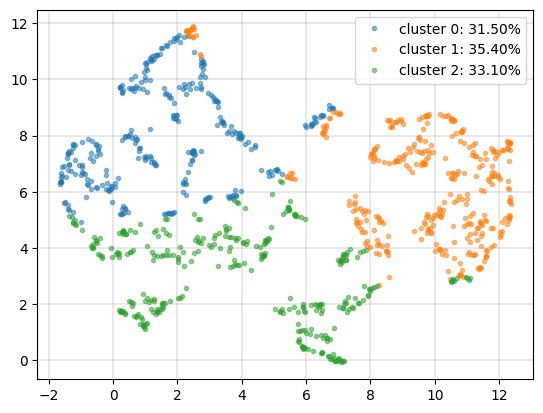

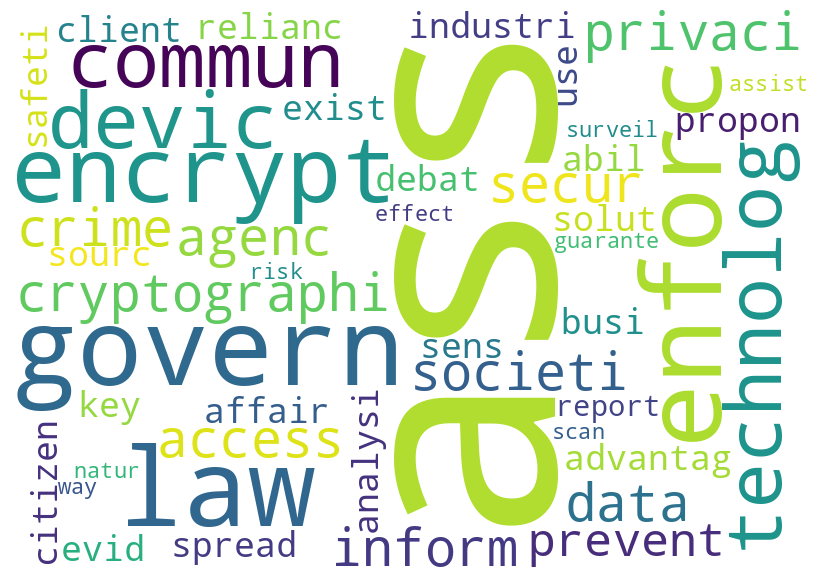

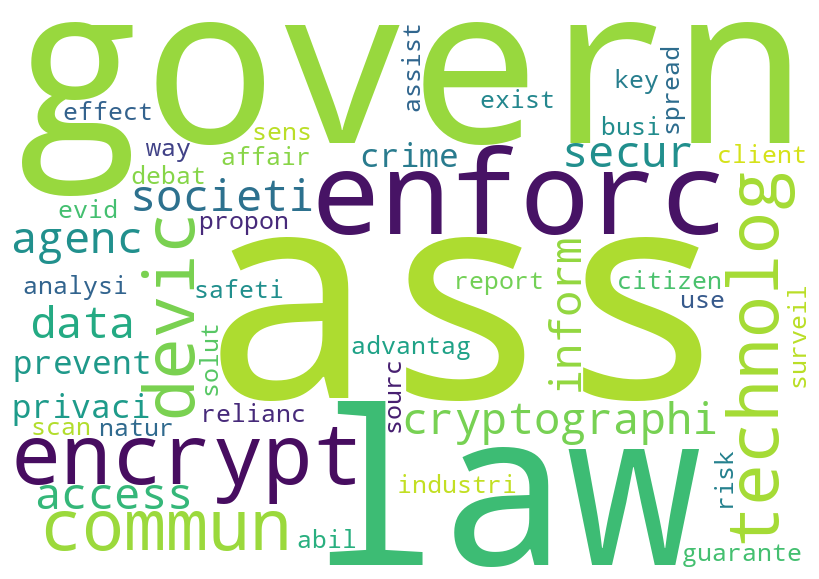

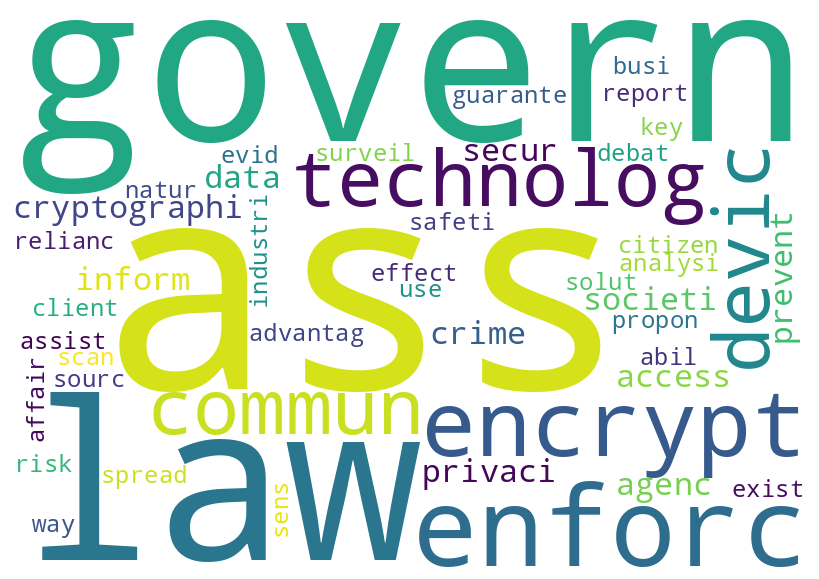

In [9]:
#from model import *
#from utils import *

import pandas as pd
import pickle
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore', category=Warning)

import argparse

#def model(): #:if __name__ == '__main__':

def main():
    
    
    method = "LDA_BERT"
    samp_size = 1000
    ntopic = 3
    
    #parser = argparse.ArgumentParser(description='contextual_topic_identification tm_test:1.0')

    #parser.add_argument('--fpath', default='/kaggle/working/train.csv')
    #parser.add_argument('--ntopic', default=10,)
    #parser.add_argument('--method', default='TFIDF')
    #parser.add_argument('--samp_size', default=20500)
    
    #args = parser.parse_args()

    #data = documents #pd.read_csv('/kaggle/working/train.csv')
    #data = data.fillna('')  # only the comments has NaN's
    #rws = data.abstract
    rws = ["Our increasing reliance on digital technology for personal, economic, and government affairs has made it essential to secure the communications and devices of private citizens, businesses, and governments. This has led to pervasive use of cryptography across society. Despite its evident advantages, law enforcement and national security agencies have argued that the spread of cryptography has hindered access to evidence and intelligence. Some in industry and government now advocate a new technology to access targeted data: client-side scanning (CSS). Instead of weakening encryption or providing law enforcement with backdoor keys to decrypt communications, CSS would enable on-device analysis of data in the clear. If targeted information were detected, its existence and, potentially, its source, would be revealed to the agencies; otherwise, little or no information would leave the client device. Its proponents claim that CSS is a solution to the encryption versus public safety debate: it offers privacy -- in the sense of unimpeded end-to-end encryption -- and the ability to successfully investigate serious crime. In this report, we argue that CSS neither guarantees efficacious crime prevention nor prevents surveillance. Indeed, the effect is the opposite. CSS by its nature creates serious security and privacy risks for all society while the assistance it can provide for law enforcement is at best problematic. There are multiple ways in which client-side scanning can fail, can be evaded, and can be abused."]
    sentences, token_lists, idx_in = preprocess(rws, samp_size=samp_size)
    # Define the topic model object
    #tm = Topic_Model(k = 10), method = TFIDF)
    tm = Topic_Model(k = ntopic, method = method)
    # Fit the topic model by chosen method
    tm.fit(sentences, token_lists)
    # Evaluate using metrics
    with open("/tmp/{}.file".format(tm.id), "wb") as f:
        pickle.dump(tm, f, pickle.HIGHEST_PROTOCOL)

    print('Coherence:', get_coherence(tm, token_lists, 'c_v'))
    print('Silhouette Score:', get_silhouette(tm))
    # visualize and save img
    visualize(tm)
    for i in range(tm.k):
        get_wordcloud(tm, token_lists, i)
        
main()

In [10]:
import json
def loadJson(path):
    f = open(path)
    data = json.load(f)
    f.close()
    return data

In [14]:
subs = loadJson("interstellar.json")
txt = str.join(" ", [s[2] for s in subs])

Preprocessing raw texts ...
Preprocessing raw texts. Done!
Clustering embeddings ...
Getting vector representations for LDA ...
Getting vector representations for LDA. Done!
Getting vector representations for BERT ...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Getting vector representations for BERT. Done!
Fitting Autoencoder ...
Fitting Autoencoder Done!
32/32 [==============================] - 0s 783us/step
Clustering embeddings. Done!
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, 

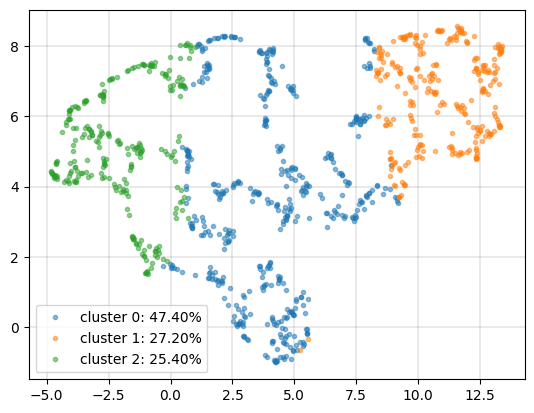

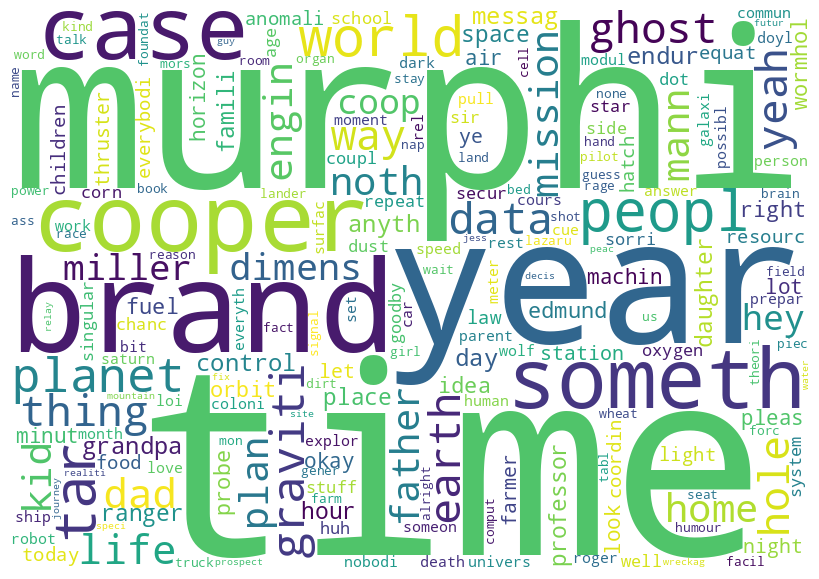

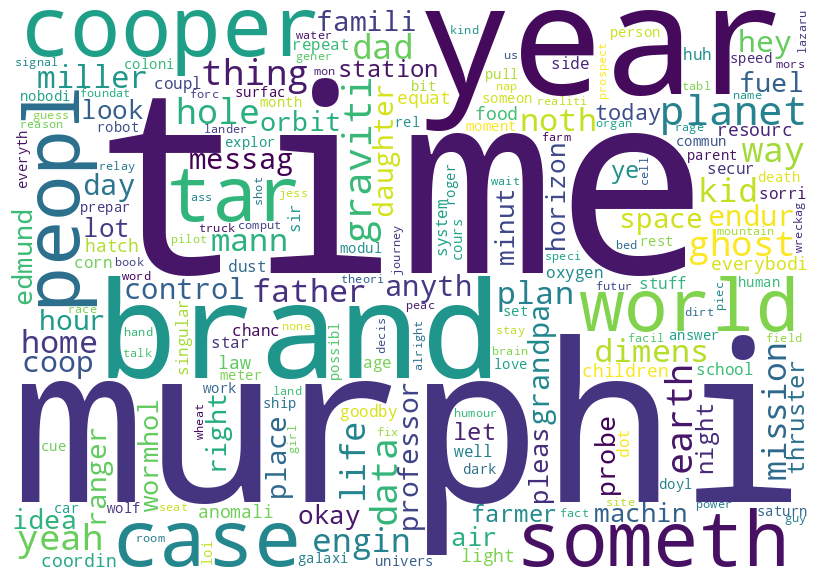

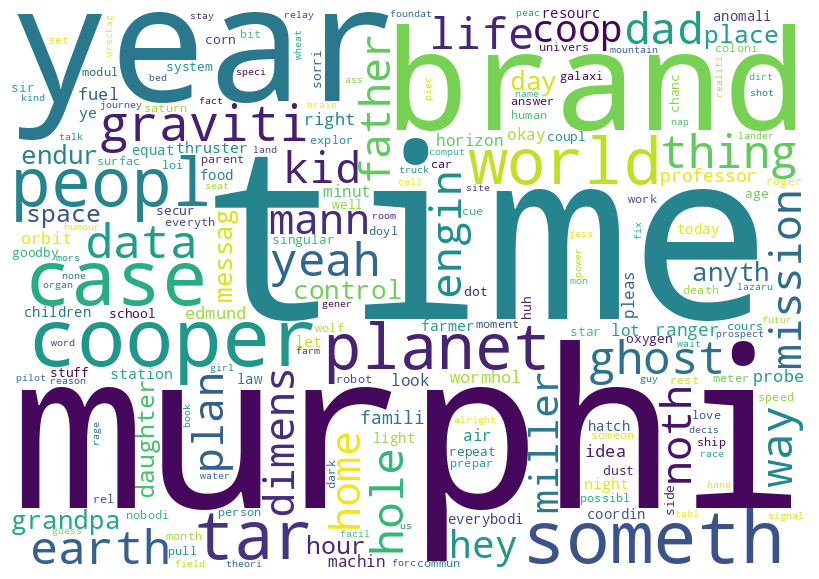

In [17]:
sentences, token_lists, idx_in = preprocess([txt], samp_size=1000)
tm = Topic_Model(k = 3, method = "LDA_BERT")
tm.fit(sentences, token_lists)
with open("/tmp/{}.file".format(tm.id), "wb") as f:
    pickle.dump(tm, f, pickle.HIGHEST_PROTOCOL)
print('Coherence:', get_coherence(tm, token_lists, 'c_v'))
print('Silhouette Score:', get_silhouette(tm))
# visualize and save img
visualize(tm)
for i in range(tm.k):
    get_wordcloud(tm, token_lists, i)

### TODO:

* Implement models.ldamulticore – parallelized Latent Dirichlet Allocation using all CPU cores to parallelize and speed up model training.
* Switch from BERT/RoBERTa to SciBERT, BART, and or other models. 